In [0]:
!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
train_downloaded = drive.CreateFile({'id':'1HjRXPKjpgnEXkJ9yrzgQQWaZR537Weal'})
train_downloaded.GetContentFile('train.csv')

In [0]:
#load library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from scipy.spatial.distance import cdist
%matplotlib inline

# set seed for reproducibility
np.random.seed(0)

In [0]:
# read in all our data
boston_marathon = pd.read_csv('train.csv')

In [0]:
pd.set_option('display.max_columns', None)

In [60]:
boston_marathon.head()

25k  age               name  division    10k gender   half  official bib  \
0  49.87   28   Cassidy, Josh R.         9  18.18      M  40.93     90.90  W1   
1  77.27   30      Korir, Wesley         5  30.90      M  64.90    132.50   1   
2  77.23   23     Desisa, Lelisa         1  30.90      M  64.92    130.37   2   
3  50.50   32  Fearnley, Kurt H.         5  18.73      M  42.00     88.43  W2   
4  48.75   39     Hokinoue, Kota         3  18.18      M  40.57     87.22  W3   

   ctz country  overall  pace state    30k     5k  genderdiv    20k     35k  \
0  NaN     CAN        9  3.47    ON  62.07   8.90          9  38.80   74.73   
1  NaN     KEN        5  5.07   NaN  92.97  15.90          5  61.52  108.78   
2  NaN     ETH        1  4.98   NaN  92.72  15.93          1  61.53  108.68   
3  NaN     AUS        5  3.38   NaN  61.35   8.98          5  39.88   73.00   
4  NaN     JPN        3  3.33   NaN  59.92   8.92          3  38.55   71.68   

       city     40k  
0   Toronto   85.55  
1     Kenya  124.77  
2      Ambo  123.78  
3  Hamilton   83.43  
4    Iizuka   81.88

In [61]:
boston_marathon.tail()

25k  age                name  division    10k gender    half  \
16159  144.85   65           Loy, Judy         6  57.57      F  121.98   
16160  133.32   64  Homeyer, Thomas F.       258  52.80      M  112.27   
16161  139.83   75     Pain, Malcolm A         3  54.97      M  117.58   
16162  135.38   80    Wilson, Harold W         1  53.13      M  113.80   
16163  144.95   61   Collins, Laurel M        49  57.57      F  121.55   

       official    bib  ctz country  overall  pace state     30k     5k  \
16159    247.47  20854  NaN     USA    17014  9.45    WA  174.75  28.50   
16160    229.72  20856  NaN     USA    13796  8.77    NY  161.00  26.57   
16161    239.97  20870  NaN     CAN    16083  9.17    NS  168.82  27.48   
16162    233.90  20907  NaN     USA    14768  8.93    TX  164.02  26.93   
16163    249.15  20908  NaN     USA    17144  9.52    CA  175.82  28.93   

       genderdiv     20k     35k       city     40k  
16159       6686  115.63  204.83  Vancouver  234.48  
16160       9024  106.38  189.82      Tully  217.88  
16161       9994  111.45  198.42    Halifax  227.53  
16162       9434  107.85  192.80      Tyler  221.42  
16163       6762  115.32  206.67   Berkeley  235.85

In [62]:
boston_marathon.shape

(16164, 21)

In [63]:
boston_marathon.columns

Index(['25k', 'age', 'name', 'division', '10k', 'gender', 'half', 'official',
       'bib', 'ctz', 'country', 'overall', 'pace', 'state', '30k', '5k',
       'genderdiv', '20k', '35k', 'city', '40k'],
      dtype='object')

In [64]:
boston_marathon.describe().T

count         mean          std    min        25%       50%  \
age        16164.0    41.638332    10.351311  18.00    34.0000    42.000   
division   16164.0  1100.967025   942.114816   1.00   363.0000   842.000   
official   16164.0   208.159470    23.743608  85.53   191.7275   209.225   
overall    16164.0  8429.373422  5052.024116   1.00  4061.7500  8247.500   
pace       16164.0     7.947398     0.905739   3.27     7.3200     7.980   
genderdiv  16164.0  4351.684732  2772.398239   1.00  2032.7500  4113.500   

                75%       max  
age           49.00     80.00  
division    1560.00   3834.00  
official     225.23    284.23  
overall    12662.25  17598.00  
pace           8.60     10.85  
genderdiv   6316.00  10648.00

## Xử lý Missing Value

In [65]:
# Số lượng điểm data bị thiếu trên mỗi cột
missing_values_count = boston_marathon.isnull().sum()

# Số lượng điểm data bị thiếu trên mỗi cột
missing_values_count

25k              0
age              0
name             0
division         0
10k              0
gender           0
half             0
official         0
bib              0
ctz          15407
country          0
overall          0
pace             0
state         1463
30k              0
5k               0
genderdiv        0
20k              0
35k              0
city             1
40k              0
dtype: int64

<b>Nhận Xét: </b>cột ctz thiếu rất nhiều dữ liệu nên xóa column này

In [0]:
boston_marathon.drop(['ctz'], axis = 1, inplace = True)

In [67]:
boston_marathon['state'].value_counts().head()

CA    1347
MA    1043
NY    1004
IL     732
ON     717
Name: state, dtype: int64

<b>Nhận Xét: </b>cột state - những giá trị xuất hiện nhiều gần như nhau nên những dòng NAN sẽ được điền với giá trị mới là NAN_VAL

In [0]:
boston_marathon['state'].fillna('NAN_VAL', inplace=True)

In [69]:
boston_marathon.shape

(16164, 20)

In [0]:
boston_marathon = boston_marathon.dropna();

In [71]:
boston_marathon.shape

(16163, 20)

In [72]:
boston_marathon.head()

25k  age               name  division    10k gender   half  official bib  \
0  49.87   28   Cassidy, Josh R.         9  18.18      M  40.93     90.90  W1   
1  77.27   30      Korir, Wesley         5  30.90      M  64.90    132.50   1   
2  77.23   23     Desisa, Lelisa         1  30.90      M  64.92    130.37   2   
3  50.50   32  Fearnley, Kurt H.         5  18.73      M  42.00     88.43  W2   
4  48.75   39     Hokinoue, Kota         3  18.18      M  40.57     87.22  W3   

  country  overall  pace    state    30k     5k  genderdiv    20k     35k  \
0     CAN        9  3.47       ON  62.07   8.90          9  38.80   74.73   
1     KEN        5  5.07  NAN_VAL  92.97  15.90          5  61.52  108.78   
2     ETH        1  4.98  NAN_VAL  92.72  15.93          1  61.53  108.68   
3     AUS        5  3.38  NAN_VAL  61.35   8.98          5  39.88   73.00   
4     JPN        3  3.33  NAN_VAL  59.92   8.92          3  38.55   71.68   

       city     40k  
0   Toronto   85.55  
1     Kenya  124.77  
2      Ambo  123.78  
3  Hamilton   83.43  
4    Iizuka   81.88

In [73]:
boston_marathon.columns

Index(['25k', 'age', 'name', 'division', '10k', 'gender', 'half', 'official',
       'bib', 'country', 'overall', 'pace', 'state', '30k', '5k', 'genderdiv',
       '20k', '35k', 'city', '40k'],
      dtype='object')

### Thống Kê số lượng dựa trên giới tính, độ tuổi

In [74]:
counts = boston_marathon[['age', 'gender', 'name']].groupby(['age', 'gender']).count()
counts.head()

name
age gender      
18  F          5
    M          8
19  F         14
    M         12
20  F         23

Text(0,0.5,'Count')

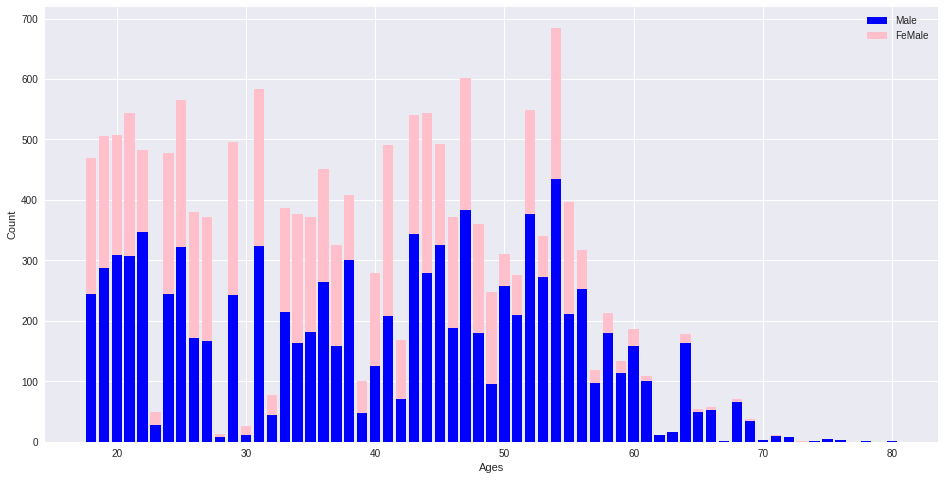

In [75]:
counts = counts.unstack(level=1)
counts.columns = counts.columns.droplevel(level=0)
counts = counts.fillna(0)
ages = boston_marathon['age'].unique()
plt.figure(figsize=(16,8))
plt.bar(ages, counts['M'], bottom=None, color='blue', label='Male')
plt.bar(ages, counts['F'], bottom=counts['M'], color='pink', label='FeMale')
plt.legend()
plt.xlabel('Ages')
plt.ylabel('Count')

<b>Nhận Xét: </b>Số lượng nam nhiều hơn số lượng nữ, số nam cao tuổi tham gia cũng nhiều hơn nữ

### Chọn column để train

In [0]:
feature_columns = ['25k', 'age', 'division', '10k', 'half', 'official',
       'overall', 'pace', '30k', '5k', 'genderdiv', '20k', '35k', '40k', 'gender', 'country', 'state', 'city']
numeric_feature_columns = ['25k', 'age', 'division', '10k', 'half', 'official',
       'overall', 'pace', '30k', '5k', 'genderdiv', '20k', '35k', '40k']
category_feature_columns = ['gender', 'country', 'state', 'city']

In [0]:
X = boston_marathon[feature_columns]

In [173]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16163 entries, 0 to 16163
Data columns (total 18 columns):
25k          16163 non-null object
age          16163 non-null int64
division     16163 non-null int64
10k          16163 non-null object
half         16163 non-null object
official     16163 non-null float64
overall      16163 non-null int64
pace         16163 non-null float64
30k          16163 non-null object
5k           16163 non-null object
genderdiv    16163 non-null int64
20k          16163 non-null object
35k          16163 non-null object
40k          16163 non-null object
gender       16163 non-null object
country      16163 non-null object
state        16163 non-null object
city         16163 non-null object
dtypes: float64(2), int64(4), object(12)
memory usage: 2.3+ MB


<b>Nhận Xét: </b> object: xóa những dòng là -, rồi chuyển qua dữ liệu loại float

In [0]:
X = X[X['25k'] != '-']

In [0]:
X['25k'] = X['25k'].astype(float)

In [0]:
X = X[X['10k'] != '-']

In [0]:
X['10k'] = X['10k'].astype(float)

In [0]:
X = X[X['half'] != '-']

In [0]:
X['half'] = X['half'].astype(float)

In [0]:
X = X[X['30k'] != '-']

In [0]:
X['30k'] = X['30k'].astype(float)

In [0]:
X = X[X['5k'] != '-']

In [0]:
X['5k'] = X['5k'].astype(float)

In [0]:
X = X[X['20k'] != '-']

In [0]:
X['20k'] = X['20k'].astype(float)

In [0]:
X = X[X['35k'] != '-']

In [0]:
X['35k'] = X['35k'].astype(float)

In [0]:
X = X[X['40k'] != '-']

In [0]:
X['40k'] = X['40k'].astype(float)

In [190]:
X.columns

Index(['25k', 'age', 'division', '10k', 'half', 'official', 'overall', 'pace',
       '30k', '5k', 'genderdiv', '20k', '35k', '40k', 'gender', 'country',
       'state', 'city'],
      dtype='object')

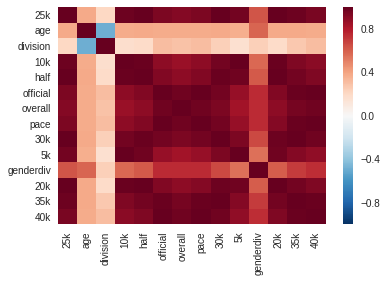

In [191]:
corr = X.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

#### standardization numeric column

In [0]:
X_origin = X

In [193]:
X_origin.head()

25k  age  division    10k   half  official  overall  pace    30k     5k  \
0  49.87   28         9  18.18  40.93     90.90        9  3.47  62.07   8.90   
1  77.27   30         5  30.90  64.90    132.50        5  5.07  92.97  15.90   
2  77.23   23         1  30.90  64.92    130.37        1  4.98  92.72  15.93   
3  50.50   32         5  18.73  42.00     88.43        5  3.38  61.35   8.98   
4  48.75   39         3  18.18  40.57     87.22        3  3.33  59.92   8.92   

   genderdiv    20k     35k     40k gender country    state      city  
0          9  38.80   74.73   85.55      M     CAN       ON   Toronto  
1          5  61.52  108.78  124.77      M     KEN  NAN_VAL     Kenya  
2          1  61.53  108.68  123.78      M     ETH  NAN_VAL      Ambo  
3          5  39.88   73.00   83.43      M     AUS  NAN_VAL  Hamilton  
4          3  38.55   71.68   81.88      M     JPN  NAN_VAL    Iizuka

In [0]:
scaler = MinMaxScaler(feature_range=(0.01, 1))
X[numeric_feature_columns] = scaler.fit_transform(X[numeric_feature_columns])

In [0]:
# X['25k'] = (X['25k'] - X['25k'].mean())/X['25k'].std()
# X['age'] = (X['age'] - X['age'].mean())/X['age'].std()
# X['division'] = (X['division'] - X['division'].mean())/X['division'].std()
# X['10k'] = (X['10k'] - X['10k'].mean())/X['10k'].std()
# X['half'] = (X['half'] - X['half'].mean())/X['half'].std()
# X['official'] = (X['official'] - X['official'].mean())/X['official'].std()
# X['overall'] = (X['overall'] - X['overall'].mean())/X['overall'].std()
# X['pace'] = (X['pace'] - X['pace'].mean())/X['pace'].std()
# X['30k'] = (X['30k'] - X['30k'].mean())/X['30k'].std()
# X['5k'] = (X['5k'] - X['5k'].mean())/X['5k'].std()
# X['genderdiv'] = (X['genderdiv'] - X['genderdiv'].mean())/X['genderdiv'].std()
# X['20k'] = (X['20k'] - X['20k'].mean())/X['20k'].std()
# X['35k'] = (X['35k'] - X['35k'].mean())/X['35k'].std()
# X['40k'] = (X['40k'] - X['40k'].mean())/X['40k'].std()

#### one hot encode những column là category

In [0]:
X = pd.get_dummies(X, columns=['gender', 'country', 'state', 'city']);

In [196]:
X.shape

(16053, 4542)

In [197]:
X_origin.shape

(16053, 18)

In [198]:
X.head()

25k       age  division       10k      half  official   overall  \
0  0.023309  0.169677  0.012066  0.013052  0.016640  0.036755  0.010450   
1  0.258573  0.201613  0.011033  0.271897  0.257802  0.244023  0.010225   
2  0.258230  0.089839  0.010000  0.271897  0.258003  0.233410  0.010000   
3  0.028718  0.233548  0.011033  0.024245  0.027405  0.024449  0.010225   
4  0.013692  0.345323  0.010517  0.013052  0.013018  0.018420  0.010113   

       pace       30k        5k  genderdiv       20k       35k       40k  \
0  0.036121  0.029013  0.011220   0.010744  0.016036  0.032199  0.036351   
1  0.245092  0.253255  0.295819   0.010372  0.256626  0.245119  0.243047   
2  0.233338  0.251440  0.297039   0.010000  0.256732  0.244493  0.237829   
3  0.024367  0.023788  0.014472   0.010372  0.027472  0.021381  0.025178   
4  0.017836  0.013411  0.012033   0.010186  0.013389  0.013127  0.017009   

   gender_F  gender_M  country_ARG  country_ARU  country_AUS  country_AUT  \
0         0         1            0            0            0            0   
1         0         1            0            0            0            0   
2         0         1            0            0            0            0   
3         0         1            0            0            1            0   
4         0         1            0            0            0            0   

   country_BAH  country_BEL  country_BER  country_BOL  country_BRA  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   country_CAN  country_CAY  country_CHI  country_CHN  country_COL  \
0            1            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   country_CRC  country_CZE  country_DEN  country_DOM  country_ECU  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   country_ESA  country_ESP  country_EST  country_ETH  country_FIN  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            1            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   country_FRA  country_GBR  country_GER  country_GRE  country_GUA  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   country_HKG  country_HUN  country_IND  country_IRL  country_ISL  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   country_ISR  country_ITA  country_JPN  country_KEN  country_KOR  \
0            0            0            0 

In [199]:
X_origin.head()

25k       age  division       10k      half  official   overall  \
0  0.023309  0.169677  0.012066  0.013052  0.016640  0.036755  0.010450   
1  0.258573  0.201613  0.011033  0.271897  0.257802  0.244023  0.010225   
2  0.258230  0.089839  0.010000  0.271897  0.258003  0.233410  0.010000   
3  0.028718  0.233548  0.011033  0.024245  0.027405  0.024449  0.010225   
4  0.013692  0.345323  0.010517  0.013052  0.013018  0.018420  0.010113   

       pace       30k        5k  genderdiv       20k       35k       40k  \
0  0.036121  0.029013  0.011220   0.010744  0.016036  0.032199  0.036351   
1  0.245092  0.253255  0.295819   0.010372  0.256626  0.245119  0.243047   
2  0.233338  0.251440  0.297039   0.010000  0.256732  0.244493  0.237829   
3  0.024367  0.023788  0.014472   0.010372  0.027472  0.021381  0.025178   
4  0.017836  0.013411  0.012033   0.010186  0.013389  0.013127  0.017009   

  gender country    state      city  
0      M     CAN       ON   Toronto  
1      M     KEN  NAN_VAL     Kenya  
2      M     ETH  NAN_VAL      Ambo  
3      M     AUS  NAN_VAL  Hamilton  
4      M     JPN  NAN_VAL    Iizuka

iter 1: 50121.932699567566
iter 2: 41628.06234889492
iter 3: 38977.867541247295
iter 4: 37478.35199048281
iter 5: 35757.64491163829
iter 6: 34911.70716461885
iter 7: 34709.275661730746
iter 8: 33962.29456949574
iter 9: 33392.55656932401


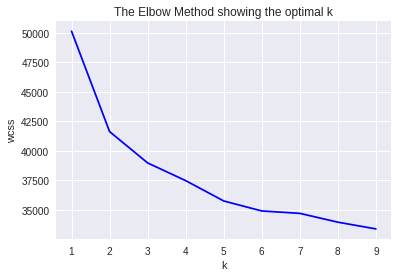

In [151]:
# k means determine k
wcss = []
K = range(1, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, init = 'k-means++', random_state = 50)
    kmeanModel.fit(X)
    wcss.append(kmeanModel.inertia_)
    print('iter ' + str(k) + ': ' + str(kmeanModel.inertia_))


# Plot the elbow
plt.plot(K, wcss, 'bx-')
plt.xlabel('k')
plt.ylabel('wcss')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [200]:
#Chọn k = 3
kmeanModel = KMeans(n_clusters=3, init = 'k-means++', random_state = 50)
kmeanModel.fit(X)
print('Sum of squared distances of samples to their closest cluster center: ' + str(kmeanModel.inertia_))

Sum of squared distances of samples to their closest cluster center: 38977.867541247295


#### Gom nhóm dữ liệu

In [0]:
X[numeric_feature_columns] = scaler.inverse_transform(X[numeric_feature_columns])

In [202]:
kmeanModel.labels_

array([0, 0, 0, ..., 0, 2, 1], dtype=int32)

In [203]:
len(kmeanModel.labels_)

16053

In [0]:
X['cluster'] = kmeanModel.labels_

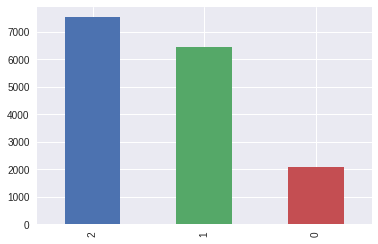

In [205]:
X['cluster'].value_counts().plot(kind='bar')

In [0]:
X_0 = X[X['cluster'] == 0]

In [0]:
X_1 = X[X['cluster'] == 1]

In [0]:
X_2 = X[X['cluster'] == 2]

In [212]:
X_0.describe()

25k          age     division          10k         half  \
count  2071.000000  2071.000000  2071.000000  2071.000000  2071.000000   
mean    112.969025    45.653790   934.141960    44.520034    94.760956   
std      13.050313     9.463757   791.239481     5.105457    10.856606   
min      48.320000    18.000000     1.000000    18.030000    40.270000   
25%     105.150000    39.000000   319.000000    41.670000    88.370000   
50%     112.870000    46.000000   765.000000    44.530000    94.670000   
75%     121.575000    52.000000  1313.500000    47.900000   101.925000   
max     149.150000    75.000000  3768.000000    58.380000   126.470000   

          official       overall         pace          30k           5k  \
count  2071.000000   2071.000000  2071.000000  2071.000000  2071.000000   
mean    200.432709   6841.684211     7.652661   137.448696    22.292434   
std      25.298157   4862.418977     0.965204    16.215986     2.580990   
min      85.530000      1.000000     3.270000    59.450000     8.870000   
25%     184.335000   2747.500000     7.030000   127.500000    20.880000   
50%     200.030000   5868.000000     7.630000   137.450000    22.330000   
75%     216.650000  10280.500000     8.270000   148.085000    23.950000   
max     270.980000  17573.000000    10.350000   181.800000    29.920000   

          genderdiv          20k          35k          40k     gender_F  \
count   2071.000000  2071.000000  2071.000000  2071.000000  2071.000000   
mean    5079.818928    89.796562   163.061878   188.992583     0.001449   
std     2977.591536    10.270586    19.785456    23.645556     0.038042   
min        1.000000    38.230000    71.180000    80.550000     0.000000   
25%     2548.500000    83.800000   150.430000   174.055000     0.000000   
50%     5028.000000    89.680000   163.080000   188.680000     0.000000   
75%     7444.000000    96.550000   176.000000   204.385000     0.000000   
max    10626.000000   119.080000   216.350000   256.320000     1.000000   

          gender_M  country_ARG  country_ARU  country_AUS  country_AUT  \
count  2071.000000  2071.000000       2071.0  2071.000000  2071.000000   
mean      0.998551     0.003863          0.0     0.027523     0.008209   
std       0.038042     0.062047          0.0     0.163641     0.090250   
min       0.000000     0.000000          0.0     0.000000     0.000000   
25%       1.000000     0.000000          0.0     0.000000     0.000000   
50%       1.000000     0.000000          0.0     0.000000     0.000000   
75%       1.000000     0.000000          0.0     0.000000     0.000000   
max       1.000000     1.000000          0.0     1.000000     1.000000   

       country_BAH  country_BEL  country_BER  country_BOL  country_BRA  \
count  2071.000000  2071.000000  2071.000000       2071.0  2071.000000   
mean      0.000483     0.003380     0.000966          0.0     0.032352   
std       0.021974     0.058054     0.031068          0.0     0.176975   
min       0.000000     0.000000     0.000000          0.0     0.000000   
25%       0.000000     0.000000     0.000000          0.0     0.000000   
50%       0.000000     0.000000     0.000000          0.0     0.000000   
75%       0.000000     0.000000     0.000000          0.0     0.000000   
max       1.000000     1.000000     1.000000          0.0     1.000000   

       country_CAN  country_CAY  country_CHI  country_CHN  country_COL  \
count  2071.000000  2071.000000  2071.000000  2071.000000  2071.000000   
mean      0.454370     0.000966     0.006760     0.002897     0.011589   
std       0.498034     0.031068     0.081961     0.053760     0.107051   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000

In [213]:
X_1.describe()

25k          age     division         10k         half  \
count  6443.000000  6443.000000  6443.000000  6443.00000  6443.000000   
mean    125.578743    38.497594  1208.447928    49.62713   105.397242   
std       8.944659     9.206273  1069.504074     3.46352     7.404802   
min      59.800000    18.000000     1.000000    23.13000    50.280000   
25%     120.220000    31.000000   350.000000    47.58000   101.010000   
50%     125.800000    38.000000   843.000000    49.78000   105.620000   
75%     131.810000    45.000000  1937.500000    51.91000   110.450000   
max     163.620000    74.000000  3834.000000    66.68000   138.670000   

          official       overall         pace          30k           5k  \
count  6443.000000   6443.000000  6443.000000  6443.000000  6443.000000   
mean    219.688831  10973.831600     8.387157   152.468688    24.880788   
std      17.174026   4038.336646     0.655076    11.131979     1.745653   
min     105.400000     24.000000     4.030000    73.300000    11.270000   
25%     208.640000   8071.500000     7.970000   145.620000    23.870000   
50%     219.730000  11203.000000     8.380000   152.820000    24.980000   
75%     232.075000  14321.500000     8.870000   160.320000    26.000000   
max     284.230000  17598.000000    10.850000   195.870000    33.220000   

         genderdiv          20k          35k          40k  gender_F  gender_M  \
count  6443.000000  6443.000000  6443.000000  6443.000000    6443.0    6443.0   
mean   3400.624088    99.898707   180.244948   207.744440       1.0       0.0   
std    1991.703711     7.020221    13.606015    16.128581       0.0       0.0   
min       1.000000    47.930000    87.370000    99.370000       1.0       0.0   
25%    1682.500000    95.740000   171.720000   197.425000       1.0       0.0   
50%    3333.000000   100.100000   180.450000   207.850000       1.0       0.0   
75%    5086.500000   104.670000   190.070000   219.470000       1.0       0.0   
max    6950.000000   131.720000   227.200000   266.120000       1.0       0.0   

       country_ARG  country_ARU  country_AUS  country_AUT  country_BAH  \
count  6443.000000  6443.000000  6443.000000  6443.000000  6443.000000   
mean      0.000621     0.000310     0.002949     0.000621     0.000155   
std       0.024911     0.017617     0.054228     0.024911     0.012458   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

       country_BEL  country_BER  country_BOL  country_BRA  country_CAN  \
count  6443.000000  6443.000000  6443.000000  6443.000000  6443.000000   
mean      0.000466     0.000466     0.000155     0.002018     0.090641   
std       0.021575     0.021575     0.012458     0.044877     0.287120   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

       country_CAY  country_CHI  country_CHN  country_COL  country_CRC  \
count  6443.000000  6443.000000  6443.000000  6443.000000  6443.000000   
mean      0.000155     0.000155     0.000310     0.000776     0.000931   
std       0.012458     0.012458     0.017617     0.027849     0.030504   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.

In [214]:
X_2.describe()

25k          age     division          10k         half  \
count  7539.000000  7539.000000  7539.000000  7539.000000  7539.000000   
mean    113.362540    43.217138  1052.883141    44.877761    95.212843   
std      12.237416    10.772667   845.624761     4.701427    10.126670   
min      52.620000    18.000000     1.000000    19.770000    43.970000   
25%     104.990000    35.000000   388.000000    41.820000    88.430000   
50%     112.620000    44.000000   860.000000    44.620000    94.530000   
75%     121.800000    51.000000  1479.000000    48.090000   102.200000   
max     158.550000    80.000000  3775.000000    62.580000   129.880000   

          official       overall         pace          30k           5k  \
count  7539.000000   7539.000000  7539.000000  7539.000000  7539.000000   
mean    200.426923   6692.541584     7.652453   137.680655    22.489507   
std      24.167074   4968.247198     0.921914    15.267333     2.343485   
min      91.780000      4.000000     3.500000    64.000000     9.370000   
25%     182.775000   2514.500000     6.980000   126.920000    20.980000   
50%     198.780000   5547.000000     7.580000   136.750000    22.380000   
75%     216.980000  10373.500000     8.280000   148.075000    24.075000   
max     282.200000  17597.000000    10.770000   191.000000    30.720000   

          genderdiv          20k          35k          40k  gender_F  \
count   7539.000000  7539.000000  7539.000000  7539.000000    7539.0   
mean    4960.586815    90.249105   163.129761   189.090245       0.0   
std     3042.134952     9.581318    18.763370    22.589473       0.0   
min        4.000000    41.770000    75.950000    86.480000       0.0   
25%     2338.500000    83.830000   149.470000   172.490000       0.0   
50%     4807.000000    89.580000   161.870000   187.530000       0.0   
75%     7486.000000    96.850000   175.660000   204.350000       0.0   
max    10648.000000   123.180000   229.500000   268.400000       0.0   

       gender_M  country_ARG  country_ARU  country_AUS  country_AUT  \
count    7539.0       7539.0       7539.0       7539.0       7539.0   
mean        1.0          0.0          0.0          0.0          0.0   
std         0.0          0.0          0.0          0.0          0.0   
min         1.0          0.0          0.0          0.0          0.0   
25%         1.0          0.0          0.0          0.0          0.0   
50%         1.0          0.0          0.0          0.0          0.0   
75%         1.0          0.0          0.0          0.0          0.0   
max         1.0          0.0          0.0          0.0          0.0   

       country_BAH  country_BEL  country_BER  country_BOL  country_BRA  \
count       7539.0       7539.0       7539.0       7539.0       7539.0   
mean           0.0          0.0          0.0          0.0          0.0   
std            0.0          0.0          0.0          0.0          0.0   
min            0.0          0.0          0.0          0.0          0.0   
25%            0.0          0.0          0.0          0.0          0.0   
50%            0.0          0.0          0.0          0.0          0.0   
75%            0.0          0.0          0.0          0.0          0.0   
max            0.0          0.0          0.0          0.0          0.0   

       country_CAN  country_CAY  country_CHI  country_CHN  country_COL  \
count       7539.0       7539.0       7539.0       7539.0       7539.0   
mean           0.0          0.0          0.0          0.0          0.0   
std            0.0          0.0          0.0          0.0          0.0   
min            0.0          0.0          0.0          0.0          0.0   
25%            0.0          0.0          0.0          0.0          0.0   
50%            0.0          0.0          0.0          0.0          0.0   
75%            0.0          0.0          0.0          0.0          0.0   
max            0.0          0.0          0.0          0.0          0.0   

       country_CRC  country_CZE  country_DEN  cou

**Nhận Xét: **

---


-Nhóm 0: Vừa có nam và nữ, thời gian chạy official:85.53 -> 270.98

---


-Nhóm 1: Chỉ có nữ, thời gian chạy official:105.40 -> 284.23

---


-Nhóm 2: Chỉ có nam, thời gian chạy official:91.78 -> 282.20

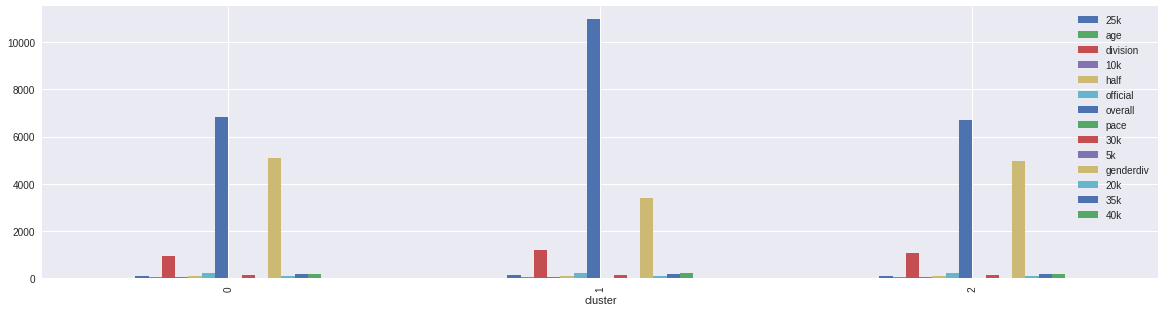

In [216]:
group_data = X.groupby('cluster')[numeric_feature_columns].mean()
group_data.plot.bar(figsize=(20, 5), grid=True)